## Sentiment Analysis Project

##### This is a sentiment analysis project that is aimed to test machine learning and deep learning models on google play store reviews.




## Library dan Tools
##### • Pandas, numpy, matplotlib, seaborn digunakan used for data manipulation and visualization
##### • Some functions from NLTK untuk text preprocessing, seperti tokenzation, Stemming, stopword removal.
##### • Google-play-scraper is the library thats used to perform data scraping on Google Play Store review applications.
##### • The rest are libraries (mostly sklearn) that is used to import machine learning and deep learning models.


In [2]:
!pip install google-play-scraper tqdm pandas numpy matplotlib seaborn transformers tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

seed = 0
np.random.seed(seed)

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


#libraries for Google Play Store Scraping
from google_play_scraper import app, reviews_all, Sort
from datetime import datetime
from tqdm import tqdm
from wordcloud import WordCloud

#ml libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Scraping Process
#### • Here we scrape data from google play store reviews from the application crunchyroll.
#### • The data that has been scraped will be put in a csv file


In [4]:
#Scraping Functions
scrapreview = reviews_all(
    'com.crunchyroll.crunchyroid',
    lang='en',
    country='us',
    sort = Sort.MOST_RELEVANT,
    count=3000
)

#save the reviews to a CSV file
with open('crunchyroll_app_reviews.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Review'])
    for review in scrapreview:
        writer.writerow([review['content']])


### Dataset Loading dan Exploratory Data Analysis
##### • Berikut merupakan function dan kode yang akan digunakan untuk melakukan EDA
##### • Kode tersebut bertujuan untuk melihat distribusi nilai, dan melakukan pengecekan jika terdapat kolom yang berisi data NaN. Jika iya, akan dilakukan data cleaning untuk membersihkan dataset tersebut.

In [5]:
app_reviews_df = pd.DataFrame(scrapreview)

num_reviews, num_columns = app_reviews_df.shape
print(f"Number of Reviews: {num_reviews}")
print(f"Number of Columns: {num_columns}")


Number of Reviews: 103500
Number of Columns: 11


<ipython-input-6-88b6336dbd34>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=app_reviews_df, palette='viridis')


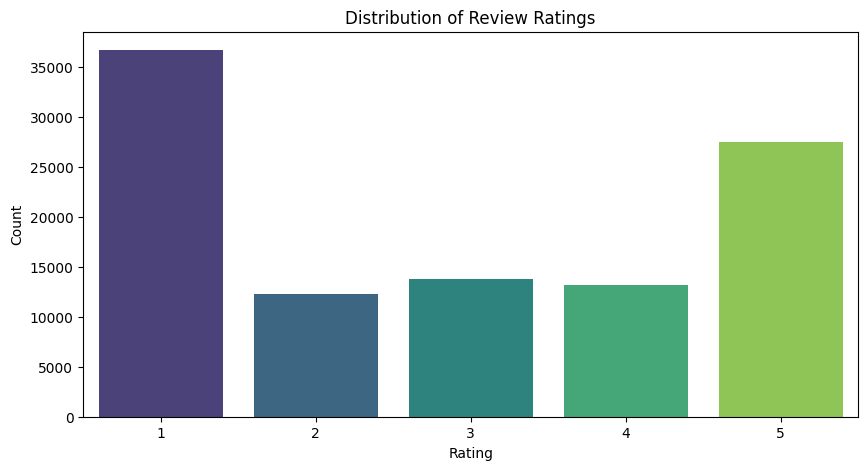

In [6]:
#Visualize Data for EDA
plt.figure(figsize=(10, 5))
sns.countplot(x='score', data=app_reviews_df, palette='viridis')
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [7]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,2642e541-3a64-44a0-8a9b-fb446d08b226,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It's a good platform with a solid selection of...,2,41,3.67.2,2024-10-13 13:14:19,"We're really sorry about the ads, Donald Loomo...",2024-10-13 13:24:57,3.67.2
1,7726a295-a8c0-45d6-b161-06da7c8e087c,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The subtitles are sometimes covered up by the ...,4,230,3.67.2,2024-10-10 00:24:14,None,NaT,3.67.2
2,aa89abbf-1096-4bd3-992f-d8533d80ed54,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"Ton of glitches, the subs aren't available on ...",1,11,3.68.0,2024-10-21 08:50:30,None,NaT,3.68.0
3,a8b570e6-fb33-4036-a395-1416bdf8007e,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This is the first time I actually have a probl...,1,5,3.68.0,2024-10-23 02:36:23,"Thanks for the review, Lenora Murphy! We're so...",2024-10-23 02:59:56,3.68.0
4,19e1fbdf-cb69-40be-b394-dc5179b7a4c1,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"App is great, but the lack of comments section...",2,0,3.68.0,2024-10-25 00:46:45,None,NaT,3.68.0


In [8]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              103500 non-null  object        
 1   userName              103500 non-null  object        
 2   userImage             103500 non-null  object        
 3   content               103499 non-null  object        
 4   score                 103500 non-null  int64         
 5   thumbsUpCount         103500 non-null  int64         
 6   reviewCreatedVersion  81871 non-null   object        
 7   at                    103500 non-null  datetime64[ns]
 8   replyContent          28573 non-null   object        
 9   repliedAt             28573 non-null   datetime64[ns]
 10  appVersion            81871 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 8.7+ MB


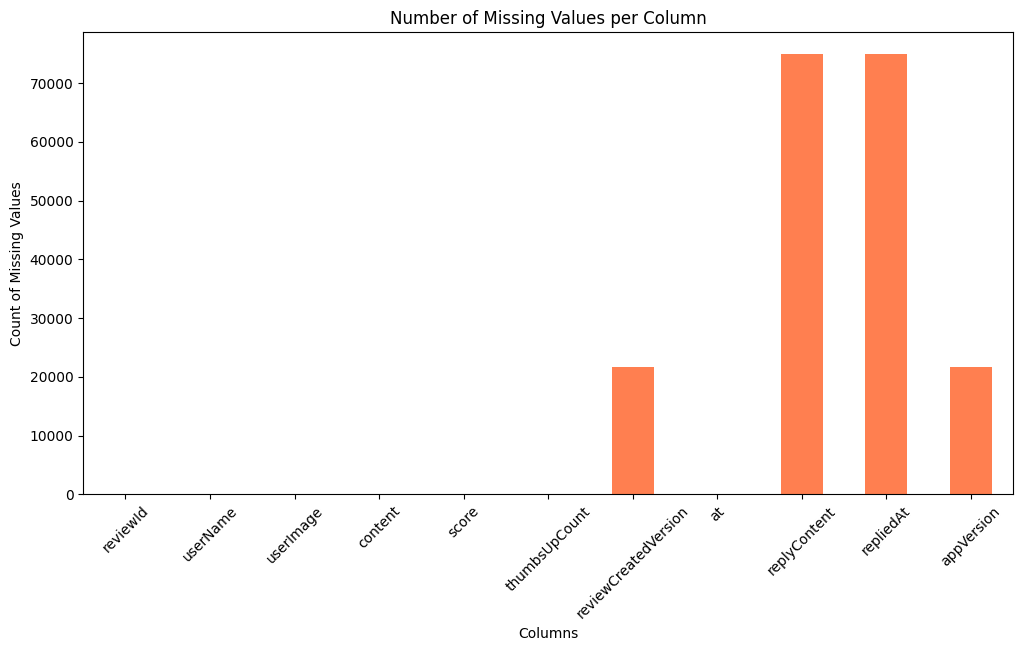

In [9]:
#look for NaN values
missing_values = app_reviews_df.isna().sum()


plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar', color='coral')
plt.title('Number of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=45)
plt.show()

### Data Cleaning
#### • We have around 160000 NaN/empty values, which means it's better that we drop that column
#### • For reviewCreatedVersion and appVersion columns, we'll be imputing similiar values just to fill them up.

In [10]:
#drop columns with alot of missing values
app_reviews_df.drop(['replyContent', 'repliedAt'], axis=1, inplace=True)

In [11]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              103500 non-null  object        
 1   userName              103500 non-null  object        
 2   userImage             103500 non-null  object        
 3   content               103499 non-null  object        
 4   score                 103500 non-null  int64         
 5   thumbsUpCount         103500 non-null  int64         
 6   reviewCreatedVersion  81871 non-null   object        
 7   at                    103500 non-null  datetime64[ns]
 8   appVersion            81871 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 7.1+ MB


In [12]:
#imput missing values
most_frequent_version = app_reviews_df['appVersion'].mode()[0]
app_reviews_df['reviewCreatedVersion'].fillna('Unknown', inplace=True)
app_reviews_df['appVersion'].fillna(most_frequent_version, inplace=True)

#check for null
print(app_reviews_df.isna().sum())

reviewId                0
userName                0
userImage               0
content                 1
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
appVersion              0
dtype: int64


<ipython-input-12-5c98e6b8f688>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_reviews_df['reviewCreatedVersion'].fillna('Unknown', inplace=True)
<ipython-input-12-5c98e6b8f688>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [13]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              103500 non-null  object        
 1   userName              103500 non-null  object        
 2   userImage             103500 non-null  object        
 3   content               103499 non-null  object        
 4   score                 103500 non-null  int64         
 5   thumbsUpCount         103500 non-null  int64         
 6   reviewCreatedVersion  103500 non-null  object        
 7   at                    103500 non-null  datetime64[ns]
 8   appVersion            103500 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 7.1+ MB


In [14]:
#Content column still has missing content, we can impute that
app_reviews_df['content'].fillna('No Content', inplace=True)

#Checking for any remaining missing values
print(app_reviews_df.isna().sum())

reviewId                0
userName                0
userImage               0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
appVersion              0
dtype: int64


<ipython-input-14-4b1f8cd5093d>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_reviews_df['content'].fillna('No Content', inplace=True)


In [15]:
#final check for data and info
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              103500 non-null  object        
 1   userName              103500 non-null  object        
 2   userImage             103500 non-null  object        
 3   content               103500 non-null  object        
 4   score                 103500 non-null  int64         
 5   thumbsUpCount         103500 non-null  int64         
 6   reviewCreatedVersion  103500 non-null  object        
 7   at                    103500 non-null  datetime64[ns]
 8   appVersion            103500 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 7.1+ MB


### Data Preprocessing
#### • In this part, we'll be using a few functions from NLTK to preprocess and clean text data.
#### • These functions will remove emojis, links, hashtags, mentions, remove stopwords, and convert all characters to lower case.

#### • We'll be applying these functions into the review dataset.

In [16]:
#initialize stemmer
stemmer = PorterStemmer()

def cleaningText(text):
    #remove mentions
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    #remove hashtags
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    #remove links
    text = re.sub(r'http\S+', '', text)
    #remove numbers
    text = re.sub(r'[0-9]+', '', text)
    text = text.replace('\n', ' ')
    #Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    #Remove leading and trailing spaces
    text = text.strip(' ')
    return text

def casefoldingText(text):
    #converts all characters to lower case
    return text.lower()
def tokenizingText(text):
    return word_tokenize(text)
def filteringText(text):
    #Get English stopwords
    listStopwords = set(stopwords.words('english'))
    #Remove stopwords
    filtered = [word for word in text if word not in listStopwords]
    return filtered
def stemmingText(text):
    #Stemming each word in the text
    stemmed_words = [stemmer.stem(word) for word in text]
    return ' '.join(stemmed_words)
def toSentence(list_words):
    #Convert list of words into a sentence
    return ' '.join(list_words)

In [17]:
app_reviews_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,2642e541-3a64-44a0-8a9b-fb446d08b226,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It's a good platform with a solid selection of...,2,41,3.67.2,2024-10-13 13:14:19,3.67.2
1,7726a295-a8c0-45d6-b161-06da7c8e087c,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The subtitles are sometimes covered up by the ...,4,230,3.67.2,2024-10-10 00:24:14,3.67.2
2,aa89abbf-1096-4bd3-992f-d8533d80ed54,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"Ton of glitches, the subs aren't available on ...",1,11,3.68.0,2024-10-21 08:50:30,3.68.0
3,a8b570e6-fb33-4036-a395-1416bdf8007e,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This is the first time I actually have a probl...,1,5,3.68.0,2024-10-23 02:36:23,3.68.0
4,19e1fbdf-cb69-40be-b394-dc5179b7a4c1,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"App is great, but the lack of comments section...",2,0,3.68.0,2024-10-25 00:46:45,3.68.0
...,...,...,...,...,...,...,...,...,...
103495,3d587da9-4710-43fd-a5c4-a711fb0263f2,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,One Piece,5,0,3.67.2,2024-10-07 03:52:01,3.67.2
103496,5cf67832-c6a4-4a32-ad6c-48900e52a652,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,One piece,5,0,3.67.2,2024-10-11 11:32:31,3.67.2
103497,727a9a24-1cb5-4bdf-8eee-d174708f6dc6,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,good,5,0,3.67.2,2024-10-04 08:19:17,3.67.2
103498,d69eefc9-5a31-4b27-a937-12fa5cff5e72,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,good,5,0,3.67.2,2024-10-09 10:09:02,3.67.2


In [18]:
#Clean the dataframe using pre-processing functions
app_reviews_df['text_clean'] = app_reviews_df['content'].apply(cleaningText)

#turning text into lowercase
app_reviews_df['text_casefoldingText'] = app_reviews_df['text_clean'].apply(casefoldingText)

#split text into tokens
app_reviews_df['text_tokenizingText'] = app_reviews_df['text_casefoldingText'].apply(tokenizingText)

#filter and remove stopwords
app_reviews_df['text_stopword'] = app_reviews_df['text_tokenizingText'].apply(filteringText)

#combining tokens and saving it as a text_final variable.
app_reviews_df['text_final'] = app_reviews_df['text_stopword'].apply(toSentence)

#Check the first few rows of the DataFrame to see the cleaned and processed text
print(app_reviews_df[['content', 'text_clean', 'text_casefoldingText',  'text_tokenizingText', 'text_stopword', 'text_final']].head())


                                             content  \
0  It's a good platform with a solid selection of...   
1  The subtitles are sometimes covered up by the ...   
2  Ton of glitches, the subs aren't available on ...   
3  This is the first time I actually have a probl...   
4  App is great, but the lack of comments section...   

                                          text_clean  \
0  Its a good platform with a solid selection of ...   
1  The subtitles are sometimes covered up by the ...   
2  Ton of glitches the subs arent available on a ...   
3  This is the first time I actually have a probl...   
4  App is great but the lack of comments section ...   

                                text_casefoldingText  \
0  its a good platform with a solid selection of ...   
1  the subtitles are sometimes covered up by the ...   
2  ton of glitches the subs arent available on a ...   
3  this is the first time i actually have a probl...   
4  app is great but the lack of comments secti

### Data Fetching & Labelling
#### • Here, we will fetch a lexicon txt dataset that can be used for data labeling.
#### • The dataset will be labeled with 3 different sentiments, which are positive, neutral, and negative. These emotions are based on a function that will calculate a score.
#### • Then we also need to visualize our labeled data to see if it is balanced or not.

In [19]:
#Data Labelling
import requests
from io import StringIO

#Increase the limit to 1,000,000 characters
csv.field_size_limit(1000000)

#Load positive lexicon data from URL
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/shekhargulati/sentiment-analysis-python/master/opinion-lexicon-English/positive-words.txt')

if response.status_code == 200:
    #Use splitlines instead of csv.reader to handle the data
    for line in response.text.splitlines():
        word = line.strip()
        #Check if the word is not empty
        if word:
            lexicon_positive[word] = 1
else:
    print("Failed to fetch positive lexicon data")

#Load negative lexicon data from a URL
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/shekhargulati/sentiment-analysis-python/master/opinion-lexicon-English/negative-words.txt')

if response.status_code == 200:

    for line in response.text.splitlines():
        word = line.strip()
        if word:
            lexicon_negative[word] = -1
else:
    print("Failed to fetch negative lexicon data")

#declare sentiment analysis lexicon
def sentiment_analysis_lexicon(text):
    score = 0

    #Calculate the score based on positive and negative words
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score += lexicon_negative[word]

    #Determine polarity based on score
    polarity = ' '
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [20]:
#apply sentiment analysis to pre-processed text column
results = app_reviews_df['text_stopword'].apply(sentiment_analysis_lexicon)
results = list(zip(*results))
app_reviews_df['polarity_score'] = results[0]
app_reviews_df['polarity'] = results[1]

#Print the value counts for each polarity
print(app_reviews_df['polarity'].value_counts())


polarity
positive    48024
neutral     30999
negative    24477
Name: count, dtype: int64


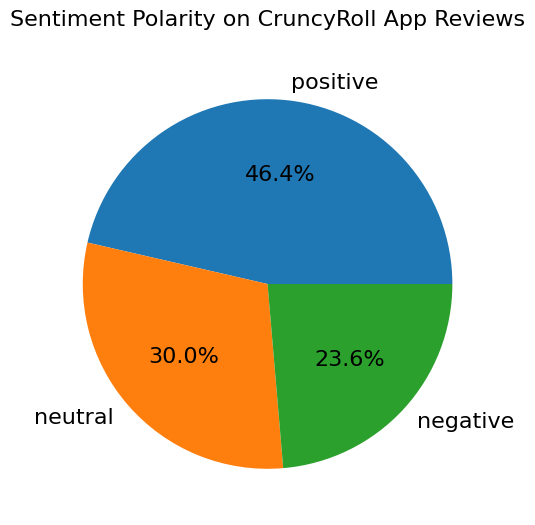

In [21]:
#Plotting sentiment polarity
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in app_reviews_df['polarity'].value_counts()]
labels = list(app_reviews_df['polarity'].value_counts().index)

#pie chart
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%',  textprops={'fontsize': 16})
ax.set_title('Sentiment Polarity on CruncyRoll App Reviews', fontsize=16, pad=20)
plt.show()

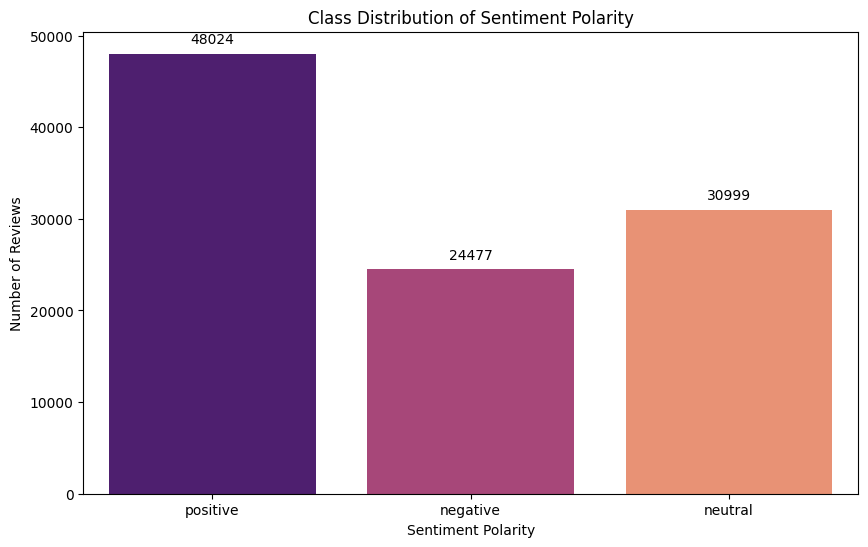

In [22]:
plt.figure(figsize=(10, 6))

#Check for class distribution
class_dist_plot = sns.countplot(x='polarity', data=app_reviews_df, hue= 'polarity', palette = "magma")
plt.title('Class Distribution of Sentiment Polarity')

#Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Reviews')
plt.show()

### Data Splitting & Feature Extraction
#### • In this part, we'll use TFIDF to execute the feature extraction process.
#### • Then, those features will be converted into a dataframe.
#### • The data will be split into 70% training and 30% testing.

In [23]:
app_reviews_df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_final,polarity_score,polarity
0,2642e541-3a64-44a0-8a9b-fb446d08b226,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It's a good platform with a solid selection of...,2,41,3.67.2,2024-10-13 13:14:19,3.67.2,Its a good platform with a solid selection of ...,its a good platform with a solid selection of ...,"[its, a, good, platform, with, a, solid, selec...","[good, platform, solid, selection, anime, howe...",good platform solid selection anime however fr...,3,positive
1,7726a295-a8c0-45d6-b161-06da7c8e087c,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The subtitles are sometimes covered up by the ...,4,230,3.67.2,2024-10-10 00:24:14,3.67.2,The subtitles are sometimes covered up by the ...,the subtitles are sometimes covered up by the ...,"[the, subtitles, are, sometimes, covered, up, ...","[subtitles, sometimes, covered, content, ratin...",subtitles sometimes covered content rating tv ...,4,positive
2,aa89abbf-1096-4bd3-992f-d8533d80ed54,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"Ton of glitches, the subs aren't available on ...",1,11,3.68.0,2024-10-21 08:50:30,3.68.0,Ton of glitches the subs arent available on a ...,ton of glitches the subs arent available on a ...,"[ton, of, glitches, the, subs, arent, availabl...","[ton, glitches, subs, arent, available, large,...",ton glitches subs arent available large amount...,-1,negative


In [24]:
#Split data into features and labels.
X = app_reviews_df['text_final']
y = app_reviews_df['polarity']

#extract features using TF-IDF
tfidf = TfidfVectorizer(max_features=4000, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

#convert features into dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

#check feature dataframe
print(features_df.head())

    aa  aap  ability  abit  able  absolute  absolutely  absorbed  absurd  abt  \
0  0.0  0.0      0.0   0.0   0.0       0.0         0.0       0.0     0.0  0.0   
1  0.0  0.0      0.0   0.0   0.0       0.0         0.0       0.0     0.0  0.0   
2  0.0  0.0      0.0   0.0   0.0       0.0         0.0       0.0     0.0  0.0   
3  0.0  0.0      0.0   0.0   0.0       0.0         0.0       0.0     0.0  0.0   
4  0.0  0.0      0.0   0.0   0.0       0.0         0.0       0.0     0.0  0.0   

   ...  youve  yrs   yt   yu  yugioh  yuri  zero  zoom  zoro  zoroto  
0  ...    0.0  0.0  0.0  0.0     0.0   0.0   0.0   0.0   0.0     0.0  
1  ...    0.0  0.0  0.0  0.0     0.0   0.0   0.0   0.0   0.0     0.0  
2  ...    0.0  0.0  0.0  0.0     0.0   0.0   0.0   0.0   0.0     0.0  
3  ...    0.0  0.0  0.0  0.0     0.0   0.0   0.0   0.0   0.0     0.0  
4  ...    0.0  0.0  0.0  0.0     0.0   0.0   0.0   0.0   0.0     0.0  

[5 rows x 3412 columns]


In [25]:
#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

#check for shapes of sets
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Training data shape: (72450, 3412), Training labels shape: (72450,)
Test data shape: (31050, 3412), Test labels shape: (31050,)


### Machine Learning  Process
#### Here, we'll test a few models such as:
#### • Random Forest
#### • Logistic Regression


#### Random Forest Model:

In [26]:
#Random Forest Model
random_forest = RandomForestClassifier(
    random_state=42
    )
random_forest.fit(X_train.toarray(), y_train)
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

print('Random Forest - Training Accuracy:', accuracy_train_rf)
print('Random Forest - Test Accuracy:', accuracy_test_rf)

Random Forest - Training Accuracy: 0.9983712905452036
Random Forest - Test Accuracy: 0.8293397745571659


#### Logistic Regression Model:

In [27]:
#logistic regression model
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)


logistic_regression.fit(X_train.toarray(), y_train)


y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())


accuracy_train_lr = accuracy_score(y_train, y_pred_train_lr)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)


print('Logistic Regression - Training Accuracy:', accuracy_train_lr)
print('Logistic Regression - Test Accuracy:', accuracy_test_lr)

Logistic Regression - Training Accuracy: 0.929247757073844
Logistic Regression - Test Accuracy: 0.9079227053140096


### Model Visualization

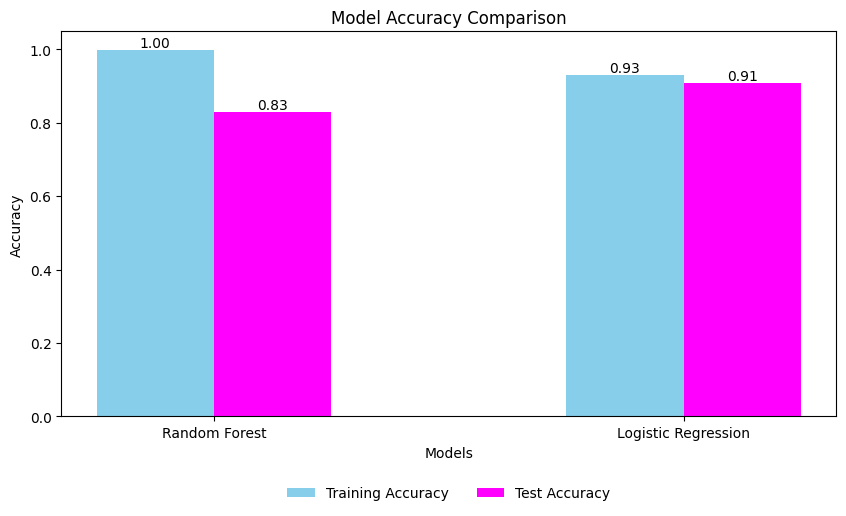

In [42]:
models = ['Random Forest', 'Logistic Regression']
train_accuracies = [accuracy_train_rf, accuracy_train_lr]
test_accuracies = [accuracy_test_rf, accuracy_test_lr]

plt.figure(figsize=(10, 5))
bar_width = 0.25
index = np.arange(len(models))

train_bars = plt.bar(index, train_accuracies, bar_width, label='Training Accuracy', color='skyblue')
test_bars = plt.bar(index + bar_width, test_accuracies, bar_width, label='Test Accuracy', color='magenta')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(index + bar_width / 2, models)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)

for bar in train_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')

for bar in test_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')

plt.show()

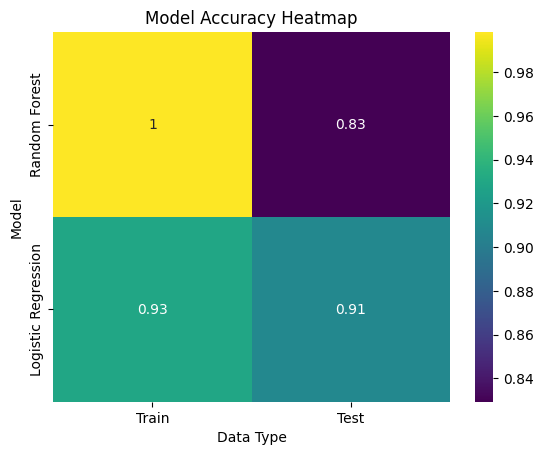

In [29]:
heatmap_data = np.array([
    [accuracy_train_rf, accuracy_test_rf],
    [accuracy_train_lr, accuracy_test_lr]
])

sns.heatmap(heatmap_data, annot=True, cmap='viridis', xticklabels=['Train', 'Test'], yticklabels=['Random Forest', 'Logistic Regression'])
plt.title('Model Accuracy Heatmap')
plt.xlabel('Data Type')
plt.ylabel('Model')
plt.show()

### Model Testing
##### Since Logistic Regression has an even and high accuracy of over 90% we'll be using it to test our model.

In [32]:
#Input a new sentence from the user
new_sentence = input("Enter a new sentence: ")

#Perform preprocessing on the new sentence
new_sentence_cleaned = cleaningText(new_sentence)
new_sentence_casefolded = casefoldingText(new_sentence_cleaned)
new_sentence_tokenized = tokenizingText(new_sentence_casefolded)
new_sentence_filtered = filteringText(new_sentence_tokenized)
new_sentence_final = toSentence(new_sentence_filtered)


X_new_sentence = tfidf.transform([new_sentence_final])


predicted_sentiment = logistic_regression.predict(X_new_sentence)

if predicted_sentiment[0] == 'positive':
    print("The sentiment of the new sentence is POSITIVE.")
elif predicted_sentiment[0] == 'negative':
    print("The sentiment of the new sentence is NEGATIVE.")
else:
    print("The sentiment of the new sentence is NEUTRAL.")


Enter a new sentence: I really disliked how the interface looked and overal it's just terrible. The app was also confusing to navigate through,
The sentiment of the new sentence is NEGATIVE.


### Saving the Model
##### Since this model will be used for Streamlit, we'll be saving it for that purpose.

In [45]:
#pickle will save the model
import pickle


#save both models
with open('random_forest_model.pkl', 'wb') as rf_file:
    pickle.dump(random_forest, rf_file)


with open('logistic_regression_model.pkl', 'wb') as lr_file:
    pickle.dump(logistic_regression, lr_file)
